In [26]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import statsmodels.api as sm
from PyEMD import EMD
from pmdarima import auto_arima
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.preprocessing import MinMaxScaler
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

In [27]:
FORECAST_STEPS = 30
ticker = "^IXIC"
data = yf.download(ticker, start="2012-01-01", end="2017-01-01")
adj_close = data['Adj Close'].to_numpy()

[*********************100%%**********************]  1 of 1 completed


In [28]:
emd = EMD()
eIMFs = emd(adj_close)

In [48]:
def apply_sarimax(data, order, forecast_steps):
    model = sm.tsa.statespace.SARIMAX(data, order=order, seasonal_order=(0,0,0,0),
                                      enforce_stationarity=False, enforce_invertibility=False)
    model_fit = model.fit(maxiter=2000)
    forecast = model_fit.forecast(steps=forecast_steps*2)
    return forecast

eIMFs_sarimax_WEIGHT_TUNING = []
eIMFs_sarimax_FORECASTING = []
for eimf in eIMFs:
    forecast = apply_sarimax(eimf[:-(FORECAST_STEPS*2)], order=(10,1,1), forecast_steps=FORECAST_STEPS)
    eIMFs_sarimax_WEIGHT_TUNING.append(forecast[:-FORECAST_STEPS])
    eIMFs_sarimax_FORECASTING.append(forecast[-FORECAST_STEPS:])


In [30]:
# series to supervised learning format
def series_to_supervised(data, n_in=1, n_out=1):
    df = pd.DataFrame(data)
    cols = []
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    agg = pd.concat(cols, axis=1)
    agg.dropna(inplace=True)
    return agg.values

In [31]:
# LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x.view(len(x), -1, 1), (h0.detach(), c0.detach()))
        out = self.linear(out[:, -1, :])
        return out

In [32]:
# train and test
eIMFs_lstm_WEIGHT_TUNING = []
eIMFs_lstm_FORECASTING = []
for data in eIMFs:
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data.reshape(-1, 1))
    reframed = series_to_supervised(scaled_data, 1, 1)
    
    train = reframed[:-(FORECAST_STEPS*2)]
    test = reframed[-(FORECAST_STEPS*2):]

    train_X, train_y = torch.FloatTensor(train[:, :-1]), torch.FloatTensor(train[:, -1])
    test_X, test_y = torch.FloatTensor(test[:, :-1]), torch.FloatTensor(test[:, -1])
    
    model = LSTMModel(input_dim = 1, hidden_dim = 32, num_layers = 2, output_dim = 1)
    criterion = nn.MSELoss(reduction='mean')
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
    
    # train
    num_epochs = 5000
    for epoch in range(num_epochs):
        outputs = model(train_X)
        outputs = outputs.squeeze()
        optimizer.zero_grad()
        loss = criterion(outputs, train_y)
        loss.backward()
        optimizer.step()
    
    # forecasting (test)
    with torch.no_grad():
        test_outputs = model(test_X)
        test_outputs = scaler.inverse_transform(test_outputs.numpy())
    eIMFs_lstm_WEIGHT_TUNING.append(test_outputs[:-FORECAST_STEPS])
    eIMFs_lstm_FORECASTING.append(test_outputs[-FORECAST_STEPS:])

In [43]:
# back from IMFs
lstm_WEIGHT_TUNING = np.sum(eIMFs_lstm_WEIGHT_TUNING, axis = 0).squeeze()
sarimax_WEIGHT_TUNING = np.sum(eIMFs_sarimax_WEIGHT_TUNING, axis=0).squeeze()

lstm_FORECASTING = np.sum(eIMFs_lstm_FORECASTING, axis = 0).squeeze()
sarimax_FORECASTING = np.sum(eIMFs_sarimax_FORECASTING, axis = 0).squeeze()

In [44]:
# weight tuning based on single-models' errors
errors_lstm = lstm_WEIGHT_TUNING - adj_close[-(FORECAST_STEPS*2):-FORECAST_STEPS]
errors_sarimax = sarimax_WEIGHT_TUNING - adj_close[-(FORECAST_STEPS*2):-FORECAST_STEPS]

weight_lstm = 1 / np.sqrt((errors_lstm ** 2).mean())
weight_sarimax = 1 / np.sqrt((errors_sarimax ** 2).mean())


In [45]:
ensemble_predictions_LSTM_SARIMAX = (lstm_FORECASTING * weight_lstm + sarimax_FORECASTING * weight_sarimax) / (weight_lstm + weight_sarimax)

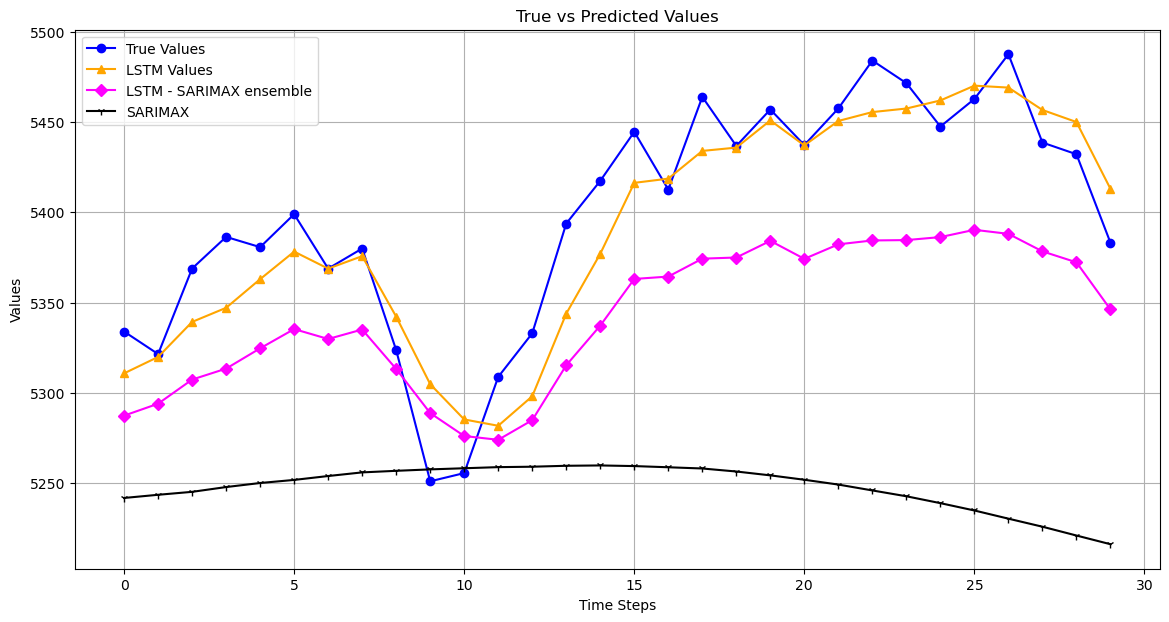

In [46]:
# plot

plt.figure(figsize=(14, 7))
plt.plot(adj_close[-FORECAST_STEPS:], label='True Values', marker='o', color='blue')

plt.plot(lstm_FORECASTING, label='LSTM Values', marker='^', color='orange')
plt.plot(ensemble_predictions_LSTM_SARIMAX, label='LSTM - SARIMAX ensemble', marker='D', color='magenta')
plt.plot(sarimax_FORECASTING, label='SARIMAX', marker='1', color='black')

plt.title('True vs Predicted Values')
plt.xlabel('Time Steps')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()

In [47]:
ensemble_errors_LSTM_SARIMAX = ensemble_predictions_LSTM_SARIMAX - adj_close[-FORECAST_STEPS:]
# metrics for model evaluation:

rmse_ensemble_LSTM_SARIMAX = np.sqrt((ensemble_errors_LSTM_SARIMAX ** 2).mean())
rmse_lstm = np.sqrt((errors_lstm ** 2).mean())
print("RMSE LSTM-SARIMAX: ", rmse_ensemble_LSTM_SARIMAX)
print("RMSE LSTM: ", rmse_lstm)

mae_lstm = np.abs(errors_lstm).mean()
mae_ensemble_LSTM_SARIMAX = np.abs(ensemble_errors_LSTM_SARIMAX).mean()
print("MAE LSTM-SARIMAX: ", mae_ensemble_LSTM_SARIMAX)

print("MAE LSTM: ", mae_lstm)

mape_lstm = (np.abs(errors_lstm / adj_close[-FORECAST_STEPS:]) * 100).mean()
mape_ensemble_LSTM_SARIMAX = (np.abs(ensemble_errors_LSTM_SARIMAX / adj_close[-FORECAST_STEPS:]) * 100).mean()
print("MAPE LSTM-SARIMAX: ", mape_ensemble_LSTM_SARIMAX)
print("MAPE LSTM model: ", mape_lstm)


RMSE LSTM-SARIMAX:  63.59127121259572
RMSE LSTM:  30.51681333299501
MAE LSTM-SARIMAX:  59.6586446359398
MAE LSTM:  23.529606119791666
MAPE LSTM-SARIMAX:  1.1013701165914012
MAPE LSTM model:  0.4345540336645323


**The hybrid model EMD-SARIMAX-LSTM doesn't outperform the EMD-LSTM model alone.**